# Señal EMG en edge impulse

In [1]:
import numpy as np
import glob
import os
import time
import hmac
import hashlib
import json
import requests
import matplotlib.pyplot as plt
import pandas as pd


## Funciones de ayuda para subir data a Edge impulse

Uploaded file to Edge Impulse 200 b'emg_signal_0.50qd43cb.json'
Uploaded file to Edge Impulse 200 b'emg_signal_1.50qd48j7.json'


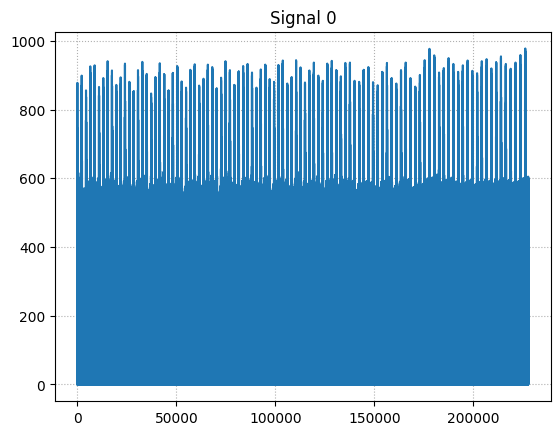

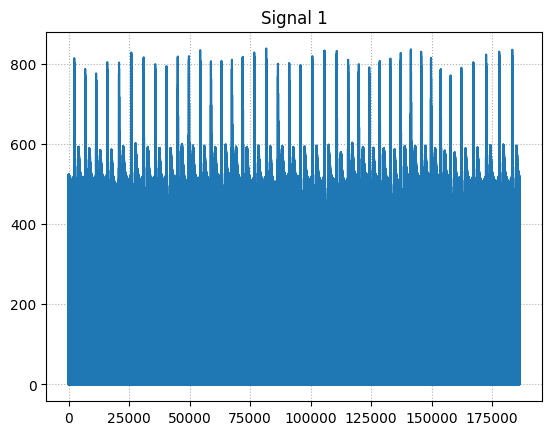

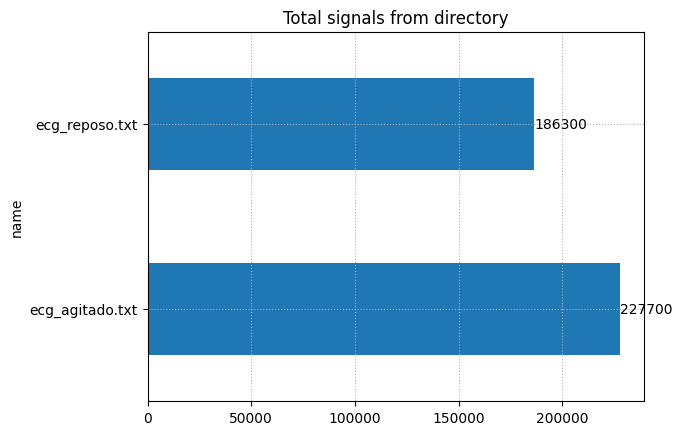

In [7]:
# Directorio de archivos EMG
path = "C:\ISB_GRUPO 1\LAB_EI\ECG"  # Cambia esta ruta al directorio donde están tus archivos .txt de EMG
files = glob.glob(os.path.join(path, "*.txt"))

if not files:
    raise FileNotFoundError(f"No se encontraron archivos .txt en el directorio: {path}")

def read_emg_file(file_path):
    return np.loadtxt(file_path)

# Leer todos los archivos y almacenar las señales en una lista
emg_signals = [read_emg_file(file) for file in files]

# Verificar que los archivos se leyeron correctamente
if not emg_signals:
    raise ValueError("No se pudieron leer las señales EMG de los archivos.")

# Ejemplo de procesamiento de una señal
def process_signal(signal):
    return signal.reshape(-1, 1)

processed_signals = [process_signal(signal) for signal in emg_signals]

# Verificar que las señales se procesaron correctamente
if not processed_signals:
    raise ValueError("No se pudieron procesar las señales EMG.")

def upload_ei(name_label, values, hmac_key, api_key):
    HMAC_KEY = hmac_key
    API_KEY = api_key
    emptySignature = ''.join(['0'] * 64)
    Fs = 1000  # Suponiendo una frecuencia de muestreo de 1000 Hz, ajusta según tu necesidad
    Ts = (1 / Fs) * 1000

    data = {
        "protected": {
            "ver": "v1",
            "alg": "HS256",
            "iat": time.time()
        },
        "signature": emptySignature,
        "payload": {
            "device_name": "ac:87:a3:0a:2d:1b",
            "device_type": "NANO33BLE",
            "interval_ms": Ts,
            "sensors": [
                {"name": "Volts", "units": "adu/mv"}
            ],
            "values": values.tolist()
        }
    }

    encoded = json.dumps(data)
    signature = hmac.new(bytes(HMAC_KEY, 'utf-8'), msg=encoded.encode('utf-8'), digestmod=hashlib.sha256).hexdigest()
    data['signature'] = signature
    encoded = json.dumps(data)

    res = requests.post(
        url='https://ingestion.edgeimpulse.com/api/training/data',
        data=encoded,
        headers={
            'Content-Type': 'application/json',
            'x-file-name': name_label,
            'x-api-key': API_KEY
        }
    )
    if res.status_code == 200:
        print('Uploaded file to Edge Impulse', res.status_code, res.content)
    else:
        print('Failed to upload file to Edge Impulse', res.status_code, res.content)

# Configuración de HMAC_KEY y API_KEY
HMAC_KEY = "a3b4de0e32797e9294c01407316b84f8"  # Tu HMAC Key
API_KEY = "ei_0ee3958480b28d18c3354e6a95be896728946cd1c7f229f722255d030e7d78e0"  # Tu API Key

# Cargar cada señal procesada a Edge Impulse
for i, signal in enumerate(processed_signals):
    name_label = f"emg_signal_{i}"
    upload_ei(name_label, signal, HMAC_KEY, API_KEY)

# Visualización de las señales
for i, signal in enumerate(processed_signals):
    plt.plot(signal)
    plt.title(f"Signal {i}")
    plt.grid(ls=":")
    plt.show()

# Análisis de los archivos leídos
df_aux = {
    "name": [os.path.basename(file) for file in files],
    "value": [len(signal) for signal in processed_signals]
}
if not df_aux['name'] or not df_aux['value']:
    raise ValueError("No hay datos disponibles para crear el gráfico.")

ax = pd.DataFrame(df_aux).plot(kind="barh", x="name", y="value", legend=False)
ax.grid(ls=":")
ax.set_title("Total signals from directory")

for bars in ax.containers:
    ax.bar_label(bars)

plt.savefig("total_signals_from_directory.png")
plt.show()